In [54]:
import sys
if ".." not in sys.path: 
    sys.path.append("..")

from src.data.Datasets import AverageSequenceDataModule

import torch
import pytorch_lightning as L
import xgboost as xgb
import numpy as np
from sklearn.metrics import log_loss, accuracy_score
from tqdm import tqdm
import seaborn as sns

In [37]:
# simulate data 

N_pos = 1000
N_neg = 1000
embedding_dim = 50
sequence_length_range = (10, 50)
embedding_data_pos = [torch.Tensor(np.random.normal(loc=0.25, scale=1, size=(np.random.randint(*sequence_length_range), embedding_dim))) for i in range(N_pos)]
embedding_data_neg = [torch.Tensor(np.random.normal(loc=0, scale=1, size=(np.random.randint(*sequence_length_range), embedding_dim))) for i in range(N_neg)]
labels_pos = torch.Tensor(np.ones((N_pos, 1)))
labels_neg = torch.Tensor(np.zeros((N_neg, 1)))
embedding_data = embedding_data_pos + embedding_data_neg
labels = torch.vstack((labels_pos, labels_neg))

embedding_dataset = AverageSequenceDataModule(embedding_data,labels, train_batch_size=5000, 
                                             val_batch_size = 5000)


In [38]:
embedding_dataset.setup(stage="train")
train_X, train_y = next(iter(embedding_dataset.train_dataloader()))
val_X, val_y = next(iter(embedding_dataset.val_dataloader()))
test_X, test_y = next(iter(embedding_dataset.test_dataloader()))


In [39]:
dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)

params = {
    "objective": "reg:logistic", 
    "tree_method": "gpu_hist"
}
n = 100

model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=n
)

In [40]:
thresh = 0.5

train_pred_scores = model.predict(dtrain)
train_preds = [1 if pred > 0.5 else 0 for pred in train_pred_scores]
train_loss = log_loss(train_y, train_pred_scores)
train_acc = accuracy_score(train_y, train_preds)

test_pred_scores = model.predict(dtest)
test_preds = [1 if pred > 0.5 else 0 for pred in test_pred_scores]
test_loss = log_loss(test_y, test_pred_scores)
test_acc = accuracy_score(test_y, test_preds)

print("train loss: ", test_loss, " train_acc: ", train_acc)
print("test loss: ", test_loss, " test_acc: ", test_acc)

train loss:  0.01673515108406644  train_acc:  1.0
test loss:  0.01673515108406644  test_acc:  0.995


In [41]:
def simulate_data(
    N_pos=1000, 
    N_neg=1000, 
    embedding_dim=50, 
    sequence_length_range=(10, 50), 
    pos_mean=0.1, 
    pos_var=1, 
    neg_mean=0, 
    neg_var=1, 
    train_batch_size=50000, 
    val_batch_size=50000, 
    test_batch_size=50000
    ) -> L.LightningDataModule: 
    
    embedding_data_pos = [
        torch.Tensor(np.random.normal(
            loc=pos_mean, scale=pos_var, size=(np.random.randint(*sequence_length_range), embedding_dim)
        )) for i in range(N_pos)
    ]
    embedding_data_neg = [
        torch.Tensor(np.random.normal(
            loc=neg_mean, scale=neg_var, size=(np.random.randint(*sequence_length_range), embedding_dim)
        )) for i in range(N_neg)]
    
    labels_pos = torch.Tensor(np.ones((N_pos, 1)))
    labels_neg = torch.Tensor(np.zeros((N_neg, 1)))
    embedding_data = embedding_data_pos + embedding_data_neg
    labels = torch.vstack((labels_pos, labels_neg))
    
    embedding_dataset = AverageSequenceDataModule(
        embedding_data,labels, 
        train_batch_size=train_batch_size, 
        val_batch_size = val_batch_size, 
        test_batch_size = test_batch_size
    )

    return embedding_dataset

In [51]:
def train_cycle(dataset, params, num_boost_round=100, class_threshold=0.5):

    dataset.setup(stage="train")
    train_X, train_y = next(iter(dataset.train_dataloader()))
    val_X, val_y = next(iter(dataset.val_dataloader()))
    test_X, test_y = next(iter(dataset.test_dataloader()))
    
    dtrain = xgb.DMatrix(train_X, train_y)
    dtest = xgb.DMatrix(test_X, test_y)
    
    model = xgb.train(
        params=params, 
        dtrain=dtrain, 
        num_boost_round=num_boost_round
    )

    train_pred_scores = model.predict(dtrain)
    train_preds = [1 if pred > class_threshold else 0 for pred in train_pred_scores]
    train_loss = log_loss(train_y, train_pred_scores)
    train_acc = accuracy_score(train_y, train_preds)
    
    test_pred_scores = model.predict(dtest)
    test_preds = [1 if pred > class_threshold else 0 for pred in test_pred_scores]
    test_loss = log_loss(test_y, test_pred_scores)
    test_acc = accuracy_score(test_y, test_preds)

    return {
        "train_loss": train_loss, 
        "train_acc": train_acc, 
        "test_loss": test_loss, 
        "test_acc": test_acc
    }

In [62]:
results = {
    "train_loss": [], 
    "train_acc": [], 
    "test_loss": [], 
    "test_acc": []
}

params = {
    "objective": "reg:logistic", 
    "tree_method": "gpu_hist"
}

n_iter = 100
means = np.logspace(0, 0.1, num = n_iter)-1
with tqdm(total=n_iter-1) as pbar: 
    for i in range(n_iter): 
        current_mean = means[i]
        current_data = simulate_data(pos_mean=current_mean, sequence_length_range=(50, 200))
        current_results = train_cycle(current_data, params )
        for key in current_results.keys():
            results[key].append(current_results[key])
        pbar.update(1)
        pbar.set_description(f"mean: {current_mean} - test_acc: {current_results['test_acc']}")

mean: 0.25892541179416706 - test_acc: 1.0: : 100it [00:52,  1.92it/s]           


<Axes: >

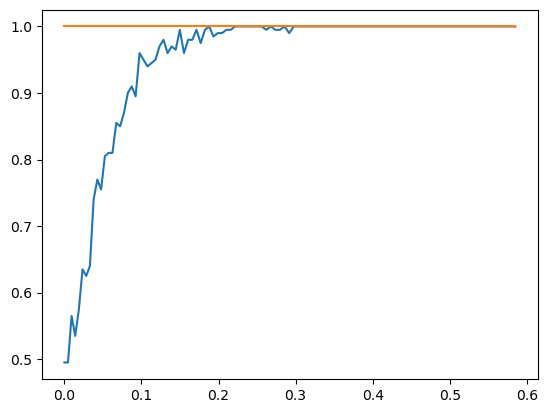

In [57]:
sns.lineplot(x = means, y=results["test_acc"])
sns.lineplot(x = means, y=results["train_acc"])

<Axes: >

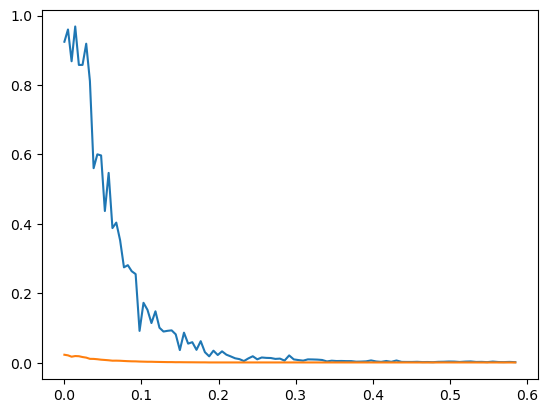

In [60]:
sns.lineplot(x = means, y=results["test_loss"])
sns.lineplot(x = means, y=results["train_loss"])

In [59]:
results["val_acc"]

KeyError: 'val_acc'

In [106]:
np.logspace(0, 1, num = 100)-1

array([0.        , 0.02353102, 0.04761575, 0.07226722, 0.09749877,
       0.12332403, 0.149757  , 0.17681195, 0.20450354, 0.23284674,
       0.26185688, 0.29154967, 0.32194115, 0.35304777, 0.38488637,
       0.41747416, 0.45082878, 0.48496826, 0.51991108, 0.55567614,
       0.59228279, 0.62975083, 0.66810054, 0.70735265, 0.7475284 ,
       0.78864953, 0.83073828, 0.87381742, 0.91791026, 0.96304065,
       1.009233  , 1.05651231, 1.10490414, 1.15443469, 1.20513074,
       1.25701972, 1.3101297 , 1.36448941, 1.42012826, 1.47707636,
       1.53536449, 1.59502421, 1.65608778, 1.71858824, 1.7825594 ,
       1.84803587, 1.91505306, 1.98364724, 2.05385551, 2.12571585,
       2.19926714, 2.27454916, 2.35160265, 2.43046929, 2.51119173,
       2.59381366, 2.67837977, 2.76493581, 2.85352859, 2.94420606,
       3.03701726, 3.1320124 , 3.22924287, 3.32876128, 3.43062146,
       3.53487851, 3.64158883, 3.75081016, 3.86260158, 3.97702356,
       4.09413801, 4.21400829, 4.33669923, 4.46227722, 4.59081